In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob


In [144]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [145]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [146]:
!cp "/content/drive/My Drive/AI_CA5_P2/UTKFace/" "UTKFace"

cp: -r not specified; omitting directory '/content/drive/My Drive/AI_CA5_P2/UTKFace/'


In [147]:

dataset_folder_name = "/content/drive/My Drive/AI_CA5_P2/UTKFace/"

TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 100

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())

In [148]:
def parse_info_from_file(path):
    try:
        filename = os.path.split(path)[1]
        filename = os.path.splitext(filename)[0]
        age, gender, race, _ = filename.split('_')

        return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
    except Exception as ex:
        return None, None, None

def parse_dataset(dataset_path, ext='jpg'):
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    labels = pd.DataFrame(records)
    labels['file'] = files
    labels.columns = ['age', 'gender', 'race', 'file']
    nan_index = labels['race'].index[labels['race'].apply(pd.isna)]
    labels = labels.dropna()
    
    return labels, nan_index

labels, nan_index = parse_dataset(dataset_folder_name)
labels.head()


,age,gender,race,file
0,26.0,female,others,/content/drive/My Drive/AI_CA5_P2/UTKFace/26_1...
1,36.0,male,black,/content/drive/My Drive/AI_CA5_P2/UTKFace/36_0...
2,34.0,male,black,/content/drive/My Drive/AI_CA5_P2/UTKFace/34_0...
3,1.0,male,white,/content/drive/My Drive/AI_CA5_P2/UTKFace/1_0_...
4,31.0,female,asian,/content/drive/My Drive/AI_CA5_P2/UTKFace/31_1...


In [149]:
print(nan_index)

Int64Index([4287, 7311, 20816], dtype='int64')


# phase1:part2

In [150]:
print(labels.shape)
print(labels.count())
print('number of age classes: ', len(labels['age'].unique()))
print('number of gender classes: ', len(labels['gender'].unique()))
print('number of race classes: ', len(labels['race'].unique()))

(23705, 4)
age       23705
gender    23705
race      23705
file      23705
dtype: int64
number of age classes:  104
number of gender classes:  2
number of race classes:  5


In [151]:
import cv2
images = os.listdir(dataset_folder_name)
print('Total number of images without dropna: ', len(images))

Total number of images without dropna:  23708


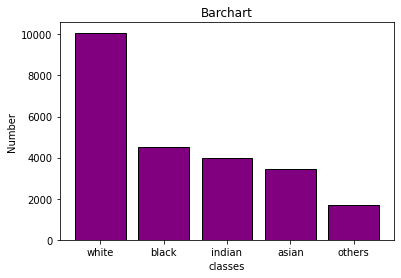

[10078, 4526, 3975, 3434, 1692]


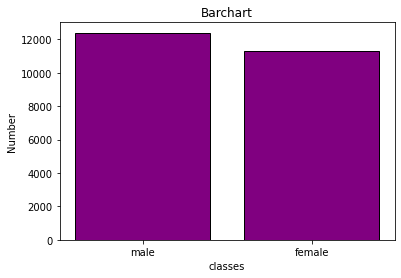

[12391, 11314]


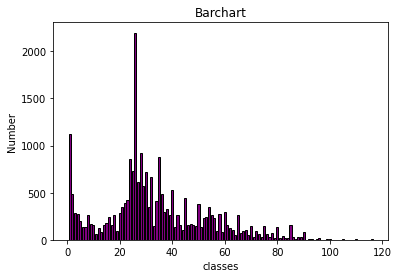

[2197, 1123, 918, 880, 859, 734, 724, 664, 615, 570, 526, 483, 482, 440, 426, 409, 395, 381, 353, 350, 346, 325, 293, 293, 289, 284, 273, 271, 268, 266, 265, 263, 262, 259, 247, 241, 236, 232, 196, 177, 170, 166, 159, 158, 157, 157, 156, 155, 153, 153, 148, 148, 147, 143, 139, 138, 133, 132, 131, 130, 125, 103, 100, 100, 98, 98, 97, 94, 82, 82, 81, 77, 69, 65, 63, 58, 56, 50, 40, 35, 34, 33, 33, 32, 28, 24, 23, 22, 18, 17, 13, 11, 10, 9, 9, 5, 5, 5, 4, 3, 2, 2, 1, 1]


In [152]:
import matplotlib.pyplot as plt

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    plt.bar(labels, counts, color="purple", edgecolor='black')
    plt.xlabel('classes')
    plt.ylabel("Number")
    plt.title("Barchart")
    plt.show()
    print(counts)
plot_distribution(labels['race'])
plot_distribution(labels['gender'])
plot_distribution(labels['age'])

In [153]:
# !pip uninstall scipy
# !pip install scipy==1.1.0

In [154]:
indices = [4287, 7311, 20816]
images = np.array(images)
images = np.delete(images, indices)

In [155]:
# labels
images.shape

(23705,)

In [156]:
from PIL import Image
import cv2
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = rgb2gray(RGB_img)    
        resized = cv2.resize(gray, (100, 100), interpolation = cv2.INTER_AREA)
        if resized is not None:
            images.append(resized)
        
    return images

data = load_images_from_folder(dataset_folder_name)
data[:10]


[array([[187.28565 , 184.145   , 175.607725, ...,  82.53035 , 145.0241  ,
         191.0195  ],
        [187.1447  , 184.394975, 176.35765 , ...,  77.780825, 139.0247  ,
         186.269975],
        [184.64495 , 182.395175, 175.24375 , ...,  73.151125, 132.645175,
         182.3902  ],
        ...,
        [ 41.8881  ,  19.8903  ,  12.891   , ..., 237.1352  , 237.385175,
         227.886125],
        [ 25.1178  ,   9.61935 ,   4.683375, ..., 235.385375, 233.885525,
         226.886225],
        [ 14.868825,   6.040725,   3.944225, ..., 232.63565 , 229.385975,
         227.886125]]),
 array([[ 35.638725,  36.138675,  37.366575, ...,  24.49315 ,  17.811575,
          16.996525],
        [ 34.38885 ,  34.38885 ,  35.1168  , ...,  29.742625,  18.811475,
          15.496675],
        [ 31.38915 ,  31.38915 ,  31.1172  , ...,  32.49235 ,  20.811275,
          16.74655 ],
        ...,
        [ 14.41255 ,  14.651725,  15.651625, ...,  78.741875,  93.22915 ,
         132.9123  ],
        [ 13

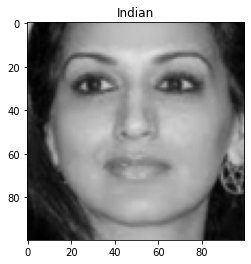

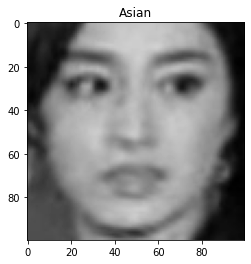

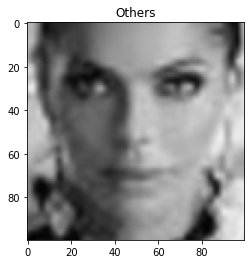

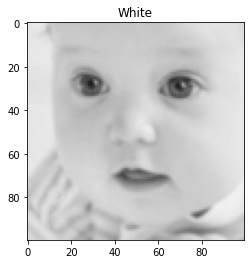

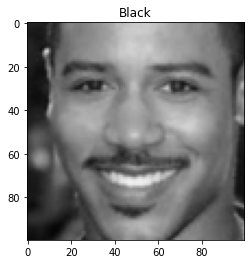

In [157]:
for i in range(23000):
  if (labels['race'][i]=='indian') :
    indian_num=i
    break
for i in range(23000):
  if (labels['race'][i]=='others') :
    others_num=i
    break
for i in range(23000):
  if (labels['race'][i]=='asian') :
    asian_num=i
    break
for i in range(23000):
  if (labels['race'][i]=='black') :
    black_num=i
    break
for i in range(23000):
  if (labels['race'][i]=='white') :
    white_num=i
    break
img_indian = cv2.imread(labels['file'][indian_num])
gray_img = cv2.cvtColor(img_indian, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(gray_img, (100, 100), interpolation = cv2.INTER_AREA)
plt.title('Indian')
plt.imshow(resized, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

img_asian = cv2.imread(labels['file'][asian_num])
gray_img = cv2.cvtColor(img_asian, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(gray_img, (100, 100), interpolation = cv2.INTER_AREA)
plt.title('Asian')
plt.imshow(resized, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

img_others = cv2.imread(labels['file'][others_num])
gray_img = cv2.cvtColor(img_others, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(gray_img, (100, 100), interpolation = cv2.INTER_AREA)
plt.title('Others')
plt.imshow(resized, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

img_white = cv2.imread(labels['file'][white_num])
gray_img = cv2.cvtColor(img_white, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(gray_img, (100, 100), interpolation = cv2.INTER_AREA)
plt.title('White')
plt.imshow(resized, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

img_black = cv2.imread(labels['file'][black_num])
gray_img = cv2.cvtColor(img_black, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(gray_img, (100, 100), interpolation = cv2.INTER_AREA)
plt.title('Black')
plt.imshow(resized, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

In [158]:
np.array(data).shape

(23708, 100, 100)

In [159]:
indices = [4287, 7311, 20816]
data = np.array(data).reshape((23708, 100, 100))
for i in indices:
  data = np.delete(data,i, axis=0)


In [160]:
data.shape

(23705, 100, 100)

In [161]:

x_train, x_test, y_train, y_test = train_test_split(data, labels['race'], test_size=0.2)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

x_train /= 255
x_test /= 255
y_train=y_train.astype('category').cat.codes
y_test=y_test.astype('category').cat.codes

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


(18964, 100, 100)
(4741, 100, 100)
(18964,)
(4741,)


In [162]:
from tensorflow.keras import regularizers
myInput = keras.layers.Input(shape=(100,100,1))
conv1 = keras.layers.Conv2D(16, 1, activation='relu', padding='same', strides=2, activity_regularizer=regularizers.l2(0.0001))(myInput)
# dropout1 = keras.layers.Dropout(0.1)(conv1)
conv2 = keras.layers.Conv2D(32, 1, activation='relu', padding='same', strides=2, activity_regularizer=regularizers.l2(0.0001))(conv1)
# dropout2 = keras.layers.Dropout(0.1)(conv2)
flat = keras.layers.Flatten()(conv2)
# dropout3 = keras.layers.Dropout(0.1)(flat)
out_layer = keras.layers.Dense(5, activation='softmax', activity_regularizer=regularizers.l2(0.0001))(flat)
myModel = Model(myInput, out_layer)
myModel.summary()
myModel.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 50, 50, 16)        32        
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 25, 25, 32)        544       
_________________________________________________________________
flatten_8 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 100005    
Total params: 100,581
Trainable params: 100,581
Non-trainable params: 0
_________________________________________________________________


In [163]:
import timeit
start = timeit.default_timer()
network_history = myModel.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.2)
end = timeit.default_timer()
print('train time :', end-start)

Epoch 1/20
475/475 [==============================] - 16s 33ms/step - loss: 1.1955 - accuracy: 0.5726 - val_loss: 1.0249 - val_accuracy: 0.6480
Epoch 2/20
475/475 [==============================] - 16s 33ms/step - loss: 0.9565 - accuracy: 0.6690 - val_loss: 0.9308 - val_accuracy: 0.6776
Epoch 3/20
475/475 [==============================] - 16s 33ms/step - loss: 0.8906 - accuracy: 0.6920 - val_loss: 0.8920 - val_accuracy: 0.6915
Epoch 4/20
475/475 [==============================] - 16s 33ms/step - loss: 0.8591 - accuracy: 0.7056 - val_loss: 0.9145 - val_accuracy: 0.6931
Epoch 5/20
475/475 [==============================] - 16s 33ms/step - loss: 0.8357 - accuracy: 0.7114 - val_loss: 0.8797 - val_accuracy: 0.6971
Epoch 6/20
475/475 [==============================] - 16s 33ms/step - loss: 0.8078 - accuracy: 0.7211 - val_loss: 0.8799 - val_accuracy: 0.6939
Epoch 7/20
475/475 [==============================] - 15s 32ms/step - loss: 0.7892 - accuracy: 0.7278 - val_loss: 0.8757 - val_accuracy:

In [164]:
y_pred = myModel.predict(x_test)

149/149 [==============================] - 2s 12ms/step - loss: 0.9680 - accuracy: 0.6826
train loss: 0.7927058935165405
test loss: 0.968029260635376


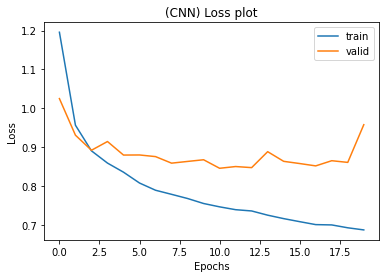

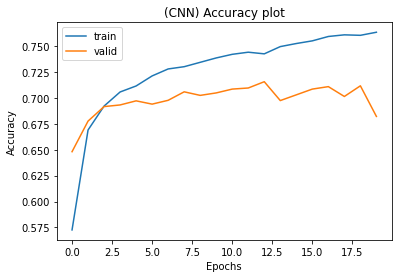

In [165]:
results_train = myModel.evaluate(x_train, y_train)
results_test = myModel.evaluate(x_test, y_test)
print('train loss: {}'.format(results_train[0]))
print('test loss: {}'.format(results_test[0]))

''''''''''''''' loss plot '''''''''''''''''

plt.plot(network_history.history['loss'], label = 'train')
plt.plot(network_history.history['val_loss'], label = 'valid')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('(CNN) Loss plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

''''''''''''''''''''''''''''''''''''''''''
plt.plot(network_history.history['accuracy'], label = 'train')
plt.plot(network_history.history['val_accuracy'], label = 'valid')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('(CNN) Accuracy plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()



In [166]:
import sklearn
print(y_pred.shape)
print(y_test.shape)

y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
sklearn.metrics.classification_report(y_test,y_pred)

(4741, 5)
(4741, 5)


'              precision    recall  f1-score   support\n\n           0       0.83      0.51      0.63       671\n           1       0.75      0.72      0.73       905\n           2       0.72      0.46      0.56       793\n           3       0.54      0.02      0.04       356\n           4       0.64      0.93      0.76      2016\n\n    accuracy                           0.68      4741\n   macro avg       0.69      0.53      0.54      4741\nweighted avg       0.69      0.68      0.65      4741\n'